<a href="https://colab.research.google.com/github/tatendatobaiwa/cnn/blob/main/CNN_Medical_Imaging_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***SIMPLE CNN MODEL BUILD FOR LUNG CANCER IMAGING***


**Step 1: Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Step 2: Create Directories in Drive**

**Step 3: Install Dependenices**

In [2]:
!pip install -q tensorflow==2.13.0
!pip install -q tensorflow-addons==0.23.0
!pip install albumentations==1.3.0
!pip install numpy==1.24.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 30.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic-core 2.27.2 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
openai 1.61.1 requires typing-extensions<5,>=4.11, but you have typing-extensions 4.5.0 which is incompatible.
nibabel 5.3.2 requires typing-extensions>=4.6; python_version < "3.13", but you have typing-extensions 4.5.0 which is incompatible.
sqlalchemy 2.0.38 requires typing-extensions>=4.6.0, but you hav

In [3]:
import tensorflow as tf
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

project_path = '/content/drive/MyDrive/CNN_Medical_Imaging_Project'
sys.path.append(project_path)

**Mini Step 3a: Verify Fixes**

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Addons version: {tfa.__version__}")

TensorFlow version: 2.13.0
TensorFlow Addons version: 0.23.0


/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Step 4: data_processing.py: Load and Preprocess Data**

In [ ]:
import cv2
import numpy as np
from pathlib import Path
import albumentations as A
from tensorflow.keras.utils import Sequence

class AlbumentationsSequence(Sequence):
    """Custom sequence for batching and augmenting images."""
    def __init__(self, images, labels, batch_size, transform):
        self.images = images  # Array of uint8 images
        self.labels = labels  # Array of integer labels or None for test data
        self.batch_size = batch_size
        self.transform = transform

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = min((idx + 1) * self.batch_size, len(self.images))
        batch_images = self.images[start:end]
        augmented = [self.transform(image=img)['image'] for img in batch_images]
        augmented = np.array(augmented)
        augmented = np.stack((augmented,) * 3, axis=-1)  # Grayscale to RGB
        if self.labels is not None:
            batch_labels = self.labels[start:end]
            return augmented, batch_labels
        return augmented

class DataProcessor:
    """Handles loading and preprocessing of image data."""
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size
        self.class_names = ['benign', 'malignant', 'normal']

    def load_images(self, data_dir):
        """Loads images and labels from a directory with class subfolders."""
        data_dir = Path(data_dir)
        images = []
        labels = []
        print(f"Loading images from {data_dir}")
        for label, class_name in enumerate(self.class_names):
            class_dir = data_dir / class_name
            if not class_dir.exists():
                print(f"Warning: Directory {class_dir} does not exist.")
                continue
            img_paths = list(class_dir.glob('*.[jpg][png][jpeg]'))
            print(f"Found {len(img_paths)} images in {class_name}")
            for img_path in img_paths:
                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, self.target_size)
                    images.append(img)
                    labels.append(label)
        if not images:
            raise ValueError(f"No images loaded from {data_dir}")
        images = np.array(images)
        labels = np.array(labels, dtype=np.int32)
        print(f"Total images loaded: {len(images)}")
        return images, labels, self.class_names

    def load_test_images(self, test_dir):
        """Loads unlabeled test images from a flat directory."""
        test_dir = Path(test_dir)
        images = []
        img_paths = list(test_dir.glob('*.[jpg][png][jpeg]'))
        print(f"Found {len(img_paths)} images in {test_dir}")
        for img_path in img_paths:
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, self.target_size)
                images.append(img)
        if not images:
            print(f"No test images loaded from {test_dir}")
        else:
            print(f"Total test images loaded: {len(images)}")
        return np.array(images)

    def create_generators(self, X_train, y_train, X_val, y_val, batch_size=32):
        """Creates training and validation generators with augmentation."""
        train_transform = A.Compose([
            A.Rotate(limit=20, p=0.5),
            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=0, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.ElasticTransform(alpha=34, sigma=4, p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.Normalize(mean=0.0, std=1.0),
        ])
        val_transform = A.Compose([
            A.Normalize(mean=0.0, std=1.0),
        ])
        train_gen = AlbumentationsSequence(X_train, y_train, batch_size, train_transform)
        val_gen = AlbumentationsSequence(X_val, y_val, batch_size, val_transform)
        return train_gen, val_gen

    def create_test_generator(self, X_test, batch_size=32):
        """Creates a test generator for prediction (no labels)."""
        test_transform = A.Compose([
            A.Normalize(mean=0.0, std=1.0),
        ])
        return AlbumentationsSequence(X_test, None, batch_size, test_transform)

if __name__ == "__main__":
    processor = DataProcessor()
    X_train, y_train, class_names = processor.load_images('/content/drive/MyDrive/CNN_Medical_Imaging_Project/data/raw/train')
    X_test = processor.load_test_images('/content/drive/MyDrive/CNN_Medical_Imaging_Project/data/raw/test')

**model_mobilenet.py : Model Creation Script**

In [ ]:
import tensorflow as tf

def create_mobilenet_model(input_shape=(224, 224, 3), num_classes=3):
    """Creates a MobileNetV2-based model and returns both the full model and base model."""
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze initially

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)
    return model, base_model  # Return both for fine-tuning access

if __name__ == "__main__":
    model, base_model = create_mobilenet_model()
    model.summary()

**Step 5: train.py: Model Training**

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import numpy as np
from data_processing import DataProcessor
from model_mobilenet import create_mobilenet_model

def train_model(train_gen, val_gen, class_names, epochs=50):
    """Trains and fine-tunes the model with class weights and callbacks."""
    # Ensure train_gen.labels is a NumPy array of integers
    if not isinstance(train_gen.labels, np.ndarray):
        train_gen.labels = np.array(train_gen.labels)
    train_gen.labels = train_gen.labels.astype(np.int32)

    # Debugging prints
    print("Type of train_gen.labels:", type(train_gen.labels))
    print("Shape of train_gen.labels:", train_gen.labels.shape)
    print("First few values of train_gen.labels:", train_gen.labels[:5] if len(train_gen.labels) > 0 else "Empty")

    # Validate train_gen.labels
    if len(train_gen.labels) == 0:
        raise ValueError("train_gen.labels is empty. No training labels available.")

    # Compute unique classes and class weights
    classes = np.unique(train_gen.labels)
    print("Classes:", classes)
    if len(classes) == 0:
        raise ValueError("No unique classes found in train_gen.labels.")
    print("Type of classes[0]:", type(classes[0]))
    class_weights = compute_class_weight('balanced', classes=classes, y=train_gen.labels)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
    print(f"Class weights: {class_weights_dict}")

    # Create and compile the model
    model, base_model = create_mobilenet_model(num_classes=len(class_names))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    # Initial training
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stop, checkpoint, reduce_lr],
        class_weight=class_weights_dict
    )

    # Fine-tuning: Unfreeze layers from block_13_expand
    set_trainable = False
    for layer in base_model.layers:  # Use base_model directly
        if layer.name == 'block_13_expand':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    # Recompile for fine-tuning
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tuning training
    history_fine = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stop, checkpoint, reduce_lr],
        class_weight=class_weights_dict
    )

    return model, history, history_fine

if __name__ == "__main__":
    processor = DataProcessor()

    # Load all data from the training directory
    X_train_full, y_train_full, class_names = processor.load_images('/content/drive/MyDrive/CNN_Medical_Imaging_Project/data/raw/train')

    # Debugging loaded data
    print("X_train_full shape:", X_train_full.shape)
    print("y_train_full shape:", y_train_full.shape)
    print("First few y_train_full labels:", y_train_full[:5])
    print("Class names:", class_names)

    # Check if data was loaded
    if len(X_train_full) == 0 or len(y_train_full) == 0:
        raise ValueError("No training data loaded. Verify the training directory.")

    # Split the training data into 80% training and 20% validation
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

    # Debugging split data
    print("X_train shape:", X_train.shape)
    print("X_val shape:", X_val.shape)
    print("y_train shape:", y_train.shape)
    print("y_val shape:", y_val.shape)

    # Create generators
    train_gen, val_gen = processor.create_generators(X_train, y_train, X_val, y_val)

    # Train the model
    model, history, history_fine = train_model(train_gen, val_gen, class_names)

    # Load and predict on test data (unlabeled)
    X_test = processor.load_test_images('/content/drive/MyDrive/CNN_Medical_Imaging_Project/data/raw/test')
    if len(X_test) > 0:
        test_gen = processor.create_test_generator(X_test)
        y_pred_probs = model.predict(test_gen, verbose=1)
        y_pred_classes = np.argmax(y_pred_probs, axis=1)
        print("\nPredicted classes for test images:")
        for i, pred_class in enumerate(y_pred_classes):
            print(f"Test image {i}: Predicted class = {class_names[pred_class]}")
        # Optionally save predictions
        with open('test_predictions.txt', 'w') as f:
            for i, pred_class in enumerate(y_pred_classes):
                f.write(f"Test image {i}: {class_names[pred_class]}\n")
        print("Predictions saved to 'test_predictions.txt'")
    else:
        print("No test data available. Please populate the test directory.")

Loaded 871 images from /content/drive/MyDrive/CNN_Medical_Imaging_Project/data/raw/train
Training data: (696, 224, 224), (696,)
Validation data: (175, 224, 224), (175,)
Class weights: {0: 2.4166666666666665, 1: 0.8656716417910447, 2: 0.6987951807228916}
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 1.0583 - accuracy: 0.5273

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 36s 1s/step - loss: 1.0583 - accuracy: 0.5273 - val_loss: 0.5914 - val_accuracy: 0.7257 - lr: 0.0010
Epoch 2/50
22/22 [==============================] - 39s 2s/step - loss: 0.6859 - accuracy: 0.6968 - val_loss: 0.4801 - val_accuracy: 0.7886 - lr: 0.0010
Epoch 3/50
22/22 [==============================] - 28s 1s/step - loss: 0.6051 - accuracy: 0.7443 - val_loss: 0.6399 - val_accuracy: 0.6171 - lr: 0.0010
Epoch 4/50
22/22 [==============================] - 29s 1s/step - loss: 0.6088 - accuracy: 0.7198 - val_loss: 0.3174 - val_accuracy: 0.8686 - lr: 0.0010
Epoch 5/50
22/22 [==============================] - 33s 2s/step - loss: 0.5344 - accuracy: 0.7328 - val_loss: 0.3520 - val_accuracy: 0.8286 - lr: 0.0010
Epoch 6/50
22/22 [==============================] - 29s 1s/step - loss: 0.5510 - accuracy: 0.7744 - val_loss: 0.2832 - val_accuracy: 0.9086 - lr: 0.0010
Epoch 7/50
22/22 [==============================] - 29s 1s/step - loss: 0.5283 - accuracy: 0.

AttributeError: 'Conv2D' object has no attribute 'layers'

**Step 6: evaluate.py: Model Evaluation**

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from data_processing import DataProcessor

def predict_unlabeled(model, X_test, class_names):
    """Predicts classes for unlabeled test images."""
    processor = DataProcessor()
    test_gen = processor.create_test_generator(X_test)
    y_pred_probs = model.predict(test_gen, verbose=1)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    print("\nPredicted classes for test images:")
    for i, pred_class in enumerate(y_pred_classes):
        print(f"Test image {i}: Predicted class = {class_names[pred_class]}")
    return y_pred_classes

if __name__ == "__main__":
    processor = DataProcessor()
    X_test = processor.load_test_images('/content/drive/MyDrive/CNN_Medical_Imaging_Project/data/raw/test')
    model = load_model('best_model.h5')
    if len(X_test) > 0:
        predictions = predict_unlabeled(model, X_test, processor.class_names)
    else:
        print("No test data loaded for prediction.")

Loaded 197 test images from /content/drive/MyDrive/CNN_Medical_Imaging_Project/data/raw/test


ValueError: too many values to unpack (expected 3)

**Step 7: xai.py: Implementation of Explainable AI (Grad-CAM)**

Loaded 197 test images from /content/drive/MyDrive/CNN_Medical_Imaging_Project/data/raw/test
1/1 [==============================] - 1s 826ms/step


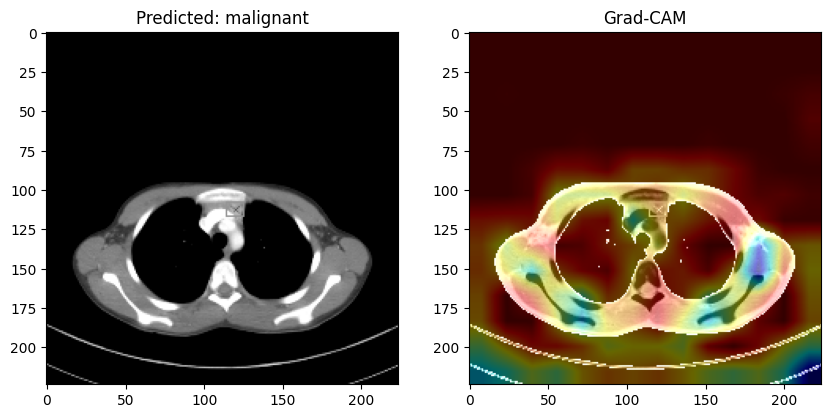

1/1 [==============================] - 0s 45ms/step


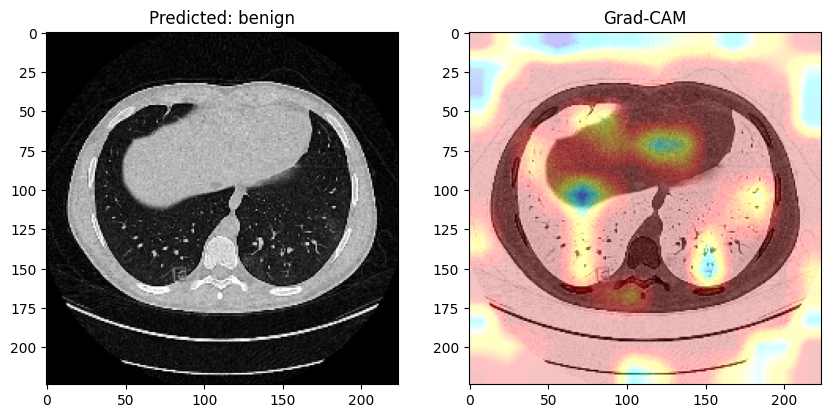

1/1 [==============================] - 0s 45ms/step


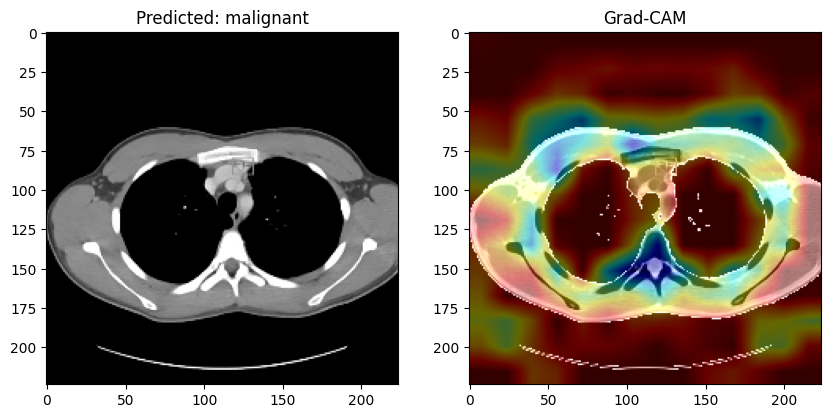

1/1 [==============================] - 0s 41ms/step


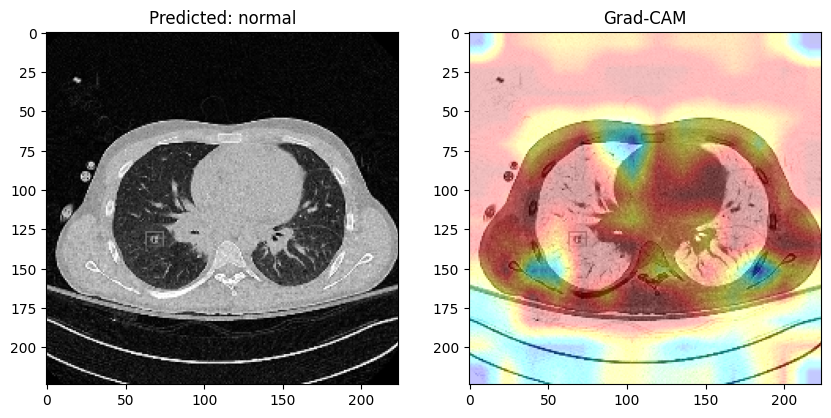

1/1 [==============================] - 0s 50ms/step


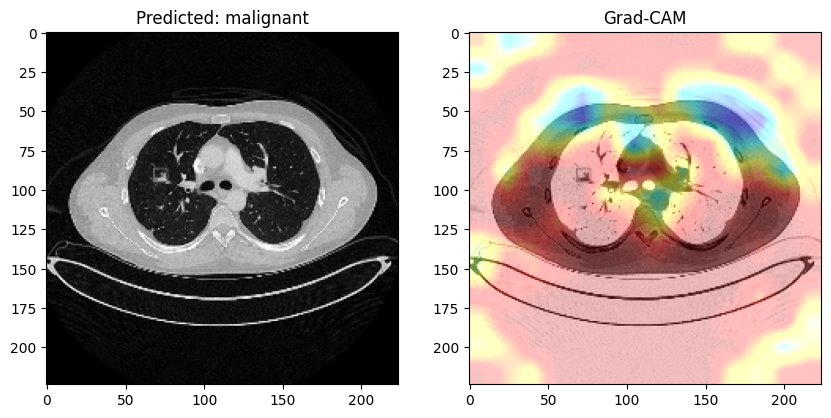

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from data_processing import DataProcessor

def get_gradcam_heatmap(model, img_array, layer_name, class_index=None):
    """Generates a Grad-CAM heatmap for a given image."""
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def superimpose_heatmap(img, heatmap, alpha=0.4):
    """Superimposes the heatmap on the original image."""
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_rgb = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB
    superimposed_img = heatmap * alpha + img_rgb * 255
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

def visualize_explanations(model, X, class_names, layer_name, num_images=5):
    """Visualizes Grad-CAM explanations for test images using predicted classes."""
    processor = DataProcessor()
    test_gen = processor.create_test_generator(X)
    for i in range(min(num_images, len(X))):
        batch_idx = i // test_gen.batch_size
        img_idx = i % test_gen.batch_size
        batch = test_gen[batch_idx]
        img = batch[img_idx:img_idx + 1]
        y_pred_probs = model.predict(img, verbose=0)
        pred_class_idx = np.argmax(y_pred_probs)
        pred_class = class_names[pred_class_idx]
        heatmap = get_gradcam_heatmap(model, img, layer_name, pred_class_idx)
        superimposed_img = superimpose_heatmap(X[i], heatmap)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(X[i], cmap='gray')
        plt.title(f'Predicted: {pred_class}')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(superimposed_img)
        plt.title('Grad-CAM')
        plt.axis('off')
        plt.show()

if __name__ == "__main__":
    processor = DataProcessor()
    X_test = processor.load_test_images('/content/drive/MyDrive/CNN_Medical_Imaging_Project/data/raw/test')
    model = load_model('best_model.h5')
    if len(X_test) > 0:
        visualize_explanations(model, X_test, processor.class_names, 'block_13_expand')
    else:
        print("No test data loaded for visualization.")